
#  **Forecasting Airline Departure Delays**

##  **About This Notebook**
- Uses *aggregated airline delay statistics*
- Focuses on **descriptive analytics** 
- Includes:
  - Data overview
  - Delay rate calculations
  - Carrier & airport analysis
  - Delay cause breakdown
  - Time-series trends
  - Simple forecasting (moving average)
  - Insight summaries for each section


##  **1.  Load Data & Inspect Structure**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

df = pd.read_csv("Airline_Delay_Cause.csv")

df.head()


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2025,7,YV,Mesa Airlines Inc.,BWI,"Baltimore, MD: Baltimore/Washington Internatio...",18.0,2.0,1.43,0.00,...,0.0,0.00,0.0,0.0,44.0,32.0,0.0,12.0,0.0,0.0
1,2025,7,YV,Mesa Airlines Inc.,CHS,"Charleston, SC: Charleston AFB/International",48.0,16.0,4.06,3.15,...,0.0,3.30,2.0,0.0,1282.0,331.0,438.0,259.0,0.0,254.0
2,2025,7,YV,Mesa Airlines Inc.,CLE,"Cleveland, OH: Cleveland-Hopkins International",65.0,10.0,3.53,1.00,...,0.0,2.43,2.0,0.0,735.0,151.0,172.0,139.0,0.0,273.0
3,2025,7,YV,Mesa Airlines Inc.,CLT,"Charlotte, NC: Charlotte Douglas International",134.0,31.0,13.19,2.43,...,0.0,4.74,8.0,0.0,2264.0,798.0,303.0,702.0,0.0,461.0
4,2025,7,YV,Mesa Airlines Inc.,CMH,"Columbus, OH: John Glenn Columbus International",61.0,12.0,6.44,0.28,...,0.0,1.69,0.0,0.0,630.0,211.0,17.0,123.0,0.0,279.0



##  **2. Create Delay Metrics**

### **How We Calculate Delay Rate**

The delay rate represents the proportion of flights that arrived **15 minutes or more past the scheduled arrival time**. It is calculated using:

$$
\text{delay\_rate} = \frac{\text{arr\_del15}}{\text{arr\_flights}}
$$


Where:

* **arr_flights** refers to the total number of arriving flights.
* **arr_del15** indicates how many of those flights experienced delays of 15 minutes or longer.

### **What This Tells Us**

The delay rate shows **the percentage of flights that were significantly delayed** for a specific airline at a specific airport during a given month.
It allows us to compare on-time performance across:

* different airlines
* different airports
* different time periods

and helps identify patterns or operational issues that contribute to delays.

In [ ]:
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]
df[
    ["year", "month", "carrier", "airport", "arr_flights", "arr_del15", "delay_rate"]
].head()


,year,month,carrier,airport,arr_flights,arr_del15,delay_rate
0,2025,7,YV,BWI,18.0,2.0,0.111111
1,2025,7,YV,CHS,48.0,16.0,0.333333
2,2025,7,YV,CLE,65.0,10.0,0.153846
3,2025,7,YV,CLT,134.0,31.0,0.231343
4,2025,7,YV,CMH,61.0,12.0,0.196721



##  **3. Overall Delay Rate Distribution**
This shows how delay rates are distributed across all airline–airport combinations.


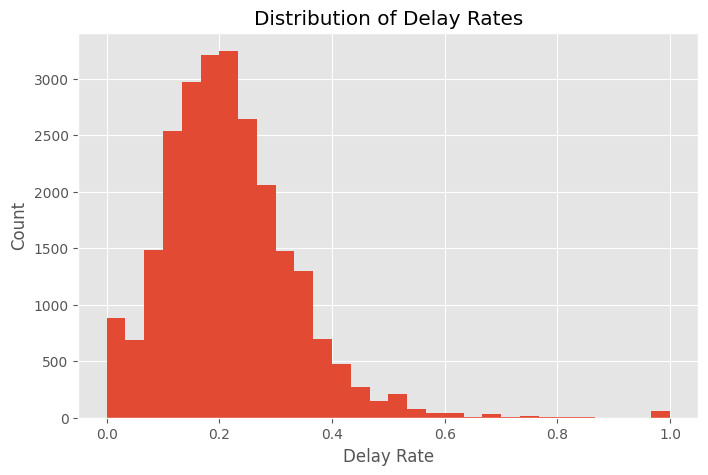

In [ ]:
df["delay_rate"].hist(bins=30, figsize=(8, 5))
plt.title("Distribution of Delay Rates")
plt.xlabel("Delay Rate")
plt.ylabel("Count");



###  **Insights**
- Most airline–airport pairs have delay rates between 10% and 25%, indicating moderate and common delays.
- The distribution is right-skewed, showing a smaller group with significantly higher delay rates.
- Very low delay rates are rare, meaning delays are a normal part of operations across most airports and carriers.
- The long right tail suggests certain airports or carriers face systemic or recurring delay issues.


#  **4. Delay Rate by Carrier**
Which airlines have the highest proportion of delayed flights?


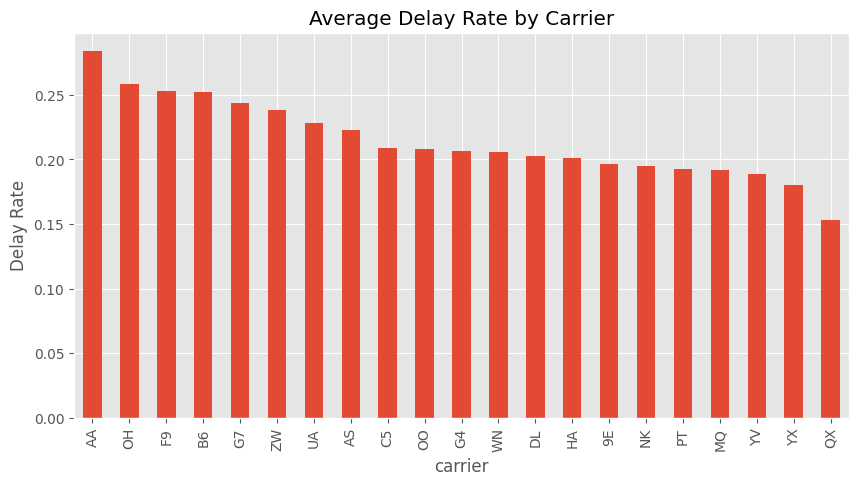

In [ ]:
carrier_delay = df.groupby("carrier")["delay_rate"].mean().sort_values(ascending=False)
carrier_delay.plot(kind="bar", figsize=(10, 5))
plt.title("Average Delay Rate by Carrier")
plt.ylabel("Delay Rate");



###  **Insights**
- Some carriers consistently show higher average delay rates, indicating more frequent late arrivals across airports.
- Carriers near the bottom of the chart have stronger on-time performance, suggesting more reliable operations.
- The spread across carriers highlights differences in operational efficiency, scheduling, and ability to manage delays.



# **5. Delay Rate by Airport**
Top 20 airports with the highest delay rates.


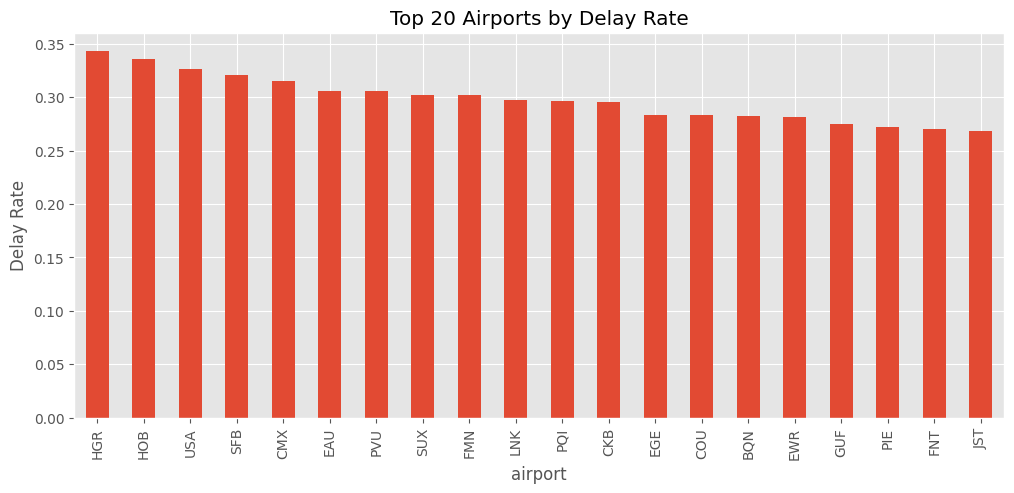

In [ ]:
airport_delay = (
    df.groupby("airport")["delay_rate"].mean().sort_values(ascending=False).head(20)
)
airport_delay.plot(kind="bar", figsize=(12, 5))
plt.title("Top 20 Airports by Delay Rate")
plt.ylabel("Delay Rate");



### **Insights**
- Airports at the top of the ranking show consistently higher delay rates, suggesting operational or environmental challenges.
- Smaller regional airports may appear with high delay rates because a few disruptions can affect a large share of flights.
- Variation across airports highlights differences in traffic volume, weather exposure, and local infrastructure.


#  **6. Delay Causes Breakdown**
We compare the **average delay minutes** attributed to:

- Carrier delay  
- Weather delay  
- NAS (National Aviation System) delay  
- Security delay  
- Late aircraft delay  



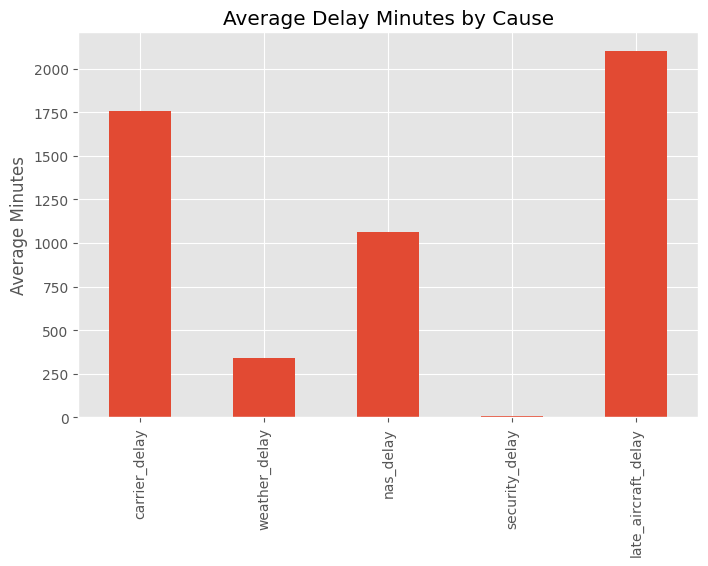

In [ ]:
cause_cols = [
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "security_delay",
    "late_aircraft_delay",
]
df[cause_cols].mean().plot(kind="bar", figsize=(8, 5))
plt.title("Average Delay Minutes by Cause")
plt.ylabel("Average Minutes");



###  **Insights**
- Late aircraft is the largest contributor to total delay minutes, indicating that delays often propagate from earlier flights.
- Carrier-related delays (e.g., maintenance, crew, operations) also account for a significant portion of total delays.
- NAS delays reflect airspace and traffic management issues and contribute meaningfully as well.
- Security delays are very rare and have minimal overall impact.
- Weather delays vary month-to-month and become more pronounced during severe seasonal conditions.



# **7. Monthly Delay Trend Over Time**

We convert `year + month` into a proper date and show national average delay rate over time.


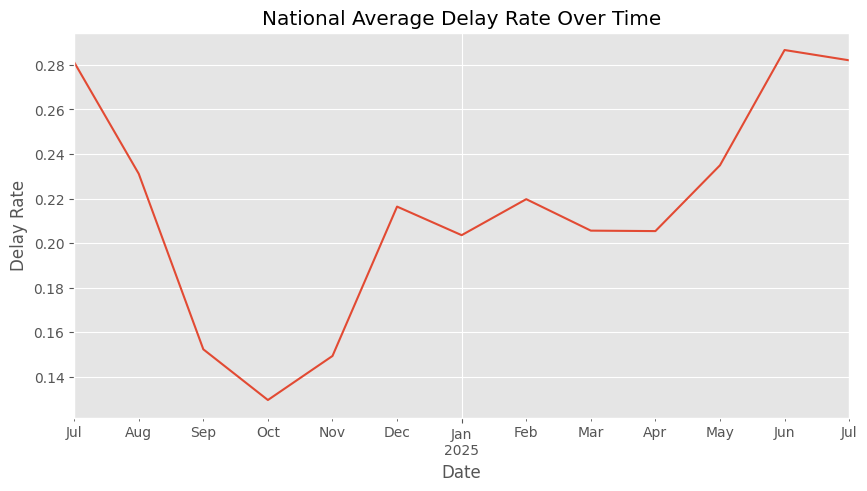

In [ ]:
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
)

monthly = df.groupby("date")["delay_rate"].mean()

monthly.plot(figsize=(10, 5))
plt.title("National Average Delay Rate Over Time")
plt.ylabel("Delay Rate")
plt.xlabel("Date");



###  **Insights**
- Delay rates fluctuate noticeably throughout the year, with peaks likely linked to seasonal weather patterns such as summer storms or winter disruptions.
- Periods with lower delay rates may reflect more stable weather and smoother operational conditions.
- The overall variation suggests that external factors like climate and demand cycles play a major role in monthly delay patterns.



# **8. Forecasting Future Airline Delay Probability and Identifying Key Delay Drivers**

A monthly time-series forecast with Prophet and an analysis of operational delay factors.

- Future forecasting（Prophet）
- Cause analysis（Linear Regression）


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet


In [89]:
df = pd.read_csv("Airline_Delay_Cause.csv")

df["date"] = pd.to_datetime(
    df["year"].astype(int).astype(str)
    + "-"
    + df["month"].astype(int).astype(str)
    + "-01"
)

monthly = df.groupby(["year", "month", "date"], as_index=False).agg(
    {
        "arr_flights": "sum",
        "arr_del15": "sum",
        "carrier_delay": "sum",
        "weather_delay": "sum",
        "nas_delay": "sum",
        "security_delay": "sum",
        "late_aircraft_delay": "sum",
        "arr_delay": "mean",
    }
)

monthly["delay_rate"] = monthly["arr_del15"] / monthly["arr_flights"]

monthly.head()


,year,month,date,arr_flights,arr_del15,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,arr_delay,delay_rate
0,2024,7,2024-07-01,676807.0,191746.0,5598426.0,741979.0,2493979.0,20965.0,6631055.0,8294.970541,0.283310
1,2024,8,2024-08-01,660639.0,150010.0,3770724.0,687328.0,2279123.0,14808.0,4540457.0,5981.165254,0.227068
2,2024,9,2024-09-01,621649.0,95112.0,2241431.0,285092.0,1065753.0,7639.0,2277525.0,3151.442359,0.153000
3,2024,10,2024-10-01,656283.0,84806.0,2198478.0,171914.0,849897.0,9090.0,1958453.0,2765.368870,0.129222
4,2024,11,2024-11-01,614597.0,89260.0,2063492.0,305657.0,1229874.0,8471.0,2065335.0,3023.896055,0.145233


In [97]:
ts = monthly[["date", "delay_rate"]].rename(columns={"date": "ds", "delay_rate": "y"})

ts.head()


,ds,y
0,2024-07-01,0.283310
1,2024-08-01,0.227068
2,2024-09-01,0.153000
3,2024-10-01,0.129222
4,2024-11-01,0.145233


In [98]:
m = Prophet()
m.fit(ts)


16:03:19 - cmdstanpy - INFO - Chain [1] start processing


16:03:19 - cmdstanpy - INFO - Chain [1] done processing


In [104]:
future = m.make_future_dataframe(periods=6, freq="M")

forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
9,2025-04-01,0.221434,0.164752,0.278296
10,2025-05-01,0.225810,0.166005,0.285005
11,2025-06-01,0.230331,0.178377,0.289311
12,2025-07-01,0.234706,0.174175,0.293674
13,2025-07-31,0.239081,0.184896,0.299664
14,2025-08-31,0.243603,0.185015,0.304188
15,2025-09-30,0.247978,0.193041,0.306821
16,2025-10-31,0.252499,0.196889,0.316667
17,2025-11-30,0.256874,0.199522,0.317055
18,2025-12-31,0.261396,0.199695,0.318485


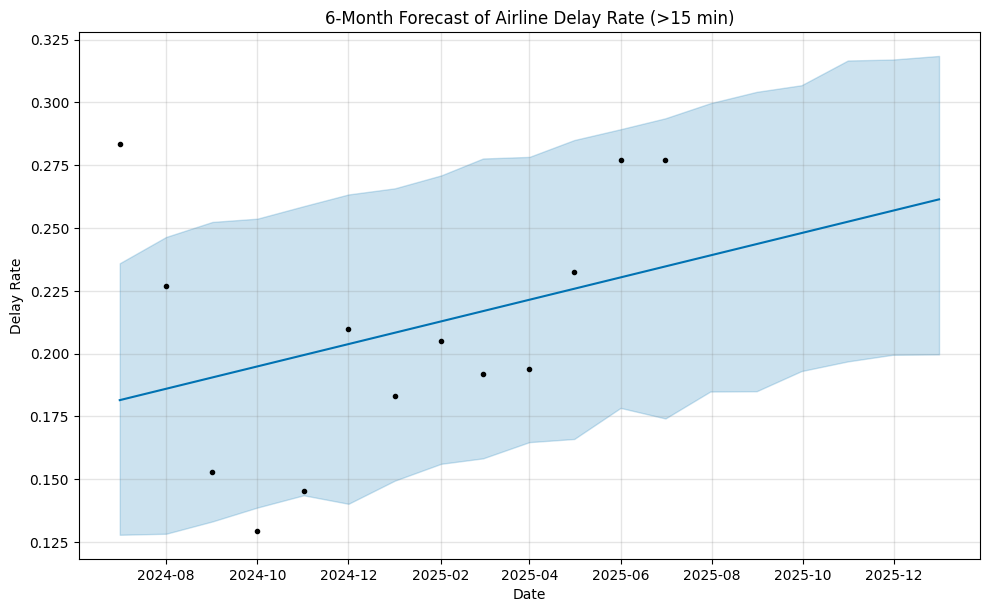

In [105]:
fig1 = m.plot(forecast)
plt.title("6-Month Forecast of Airline Delay Rate (>15 min)")
plt.xlabel("Date")
plt.ylabel("Delay Rate")
plt.show()


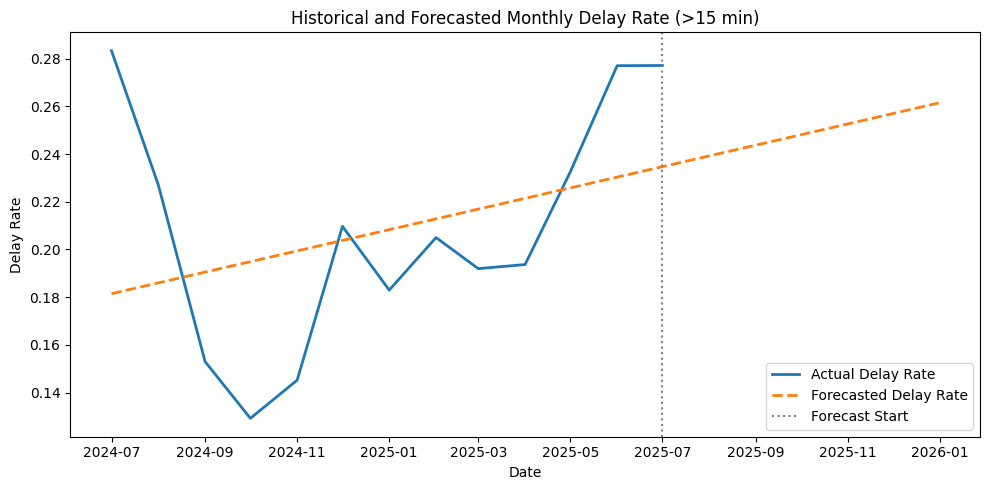

In [109]:
ts_for_merge = ts.rename(columns={"y": "y_actual"})

plot_df = forecast[["ds", "yhat"]].merge(ts_for_merge, on="ds", how="left")

plt.figure(figsize=(10, 5))

plt.plot(plot_df["ds"], plot_df["y_actual"], label="Actual Delay Rate", linewidth=2)

plt.plot(
    plot_df["ds"],
    plot_df["yhat"],
    label="Forecasted Delay Rate",
    linestyle="--",
    linewidth=2,
)

forecast_start = ts["ds"].max()
plt.axvline(forecast_start, color="gray", linestyle=":", label="Forecast Start")

plt.title("Historical and Forecasted Monthly Delay Rate (>15 min)")
plt.xlabel("Date")
plt.ylabel("Delay Rate")
plt.legend()
plt.tight_layout()
plt.show()


In [110]:
from sklearn.linear_model import LinearRegression

feature_cols = [
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "security_delay",
    "late_aircraft_delay",
]

X = monthly[feature_cols]
y = monthly["delay_rate"]

reg = LinearRegression()
reg.fit(X, y)

coef_df = pd.DataFrame({"Factor": feature_cols, "Coefficient": reg.coef_})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)
coef_df


,Factor,Coefficient,Abs_Coefficient
3,security_delay,1.095692e-06,1.095692e-06
1,weather_delay,2.926007e-08,2.926007e-08
2,nas_delay,1.998366e-08,1.998366e-08
0,carrier_delay,1.851974e-08,1.851974e-08
4,late_aircraft_delay,2.640226e-09,2.640226e-09


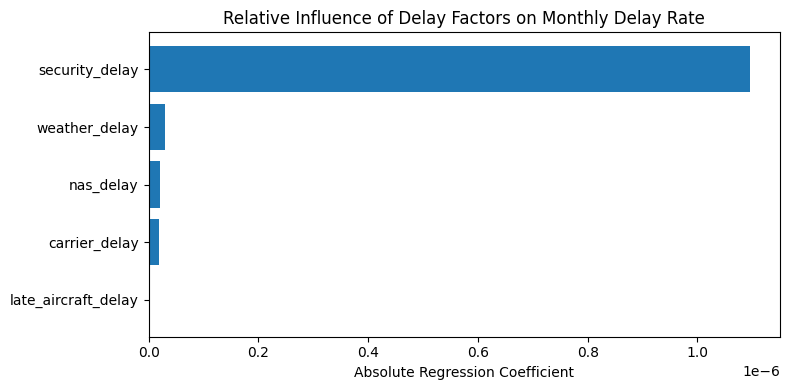

In [116]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# 1. Define features and target (monthly-level)
feature_cols = [
    "carrier_delay",
    "weather_delay",
    "nas_delay",
    "security_delay",
    "late_aircraft_delay",
]

X = monthly[feature_cols]
y = monthly["delay_rate"]

# 2. Fit linear regression model
reg = LinearRegression()
reg.fit(X, y)

# 3. Build coefficient dataframe
coef_df = pd.DataFrame({"Factor": feature_cols, "Coefficient": reg.coef_})

# Add absolute value for importance and sort
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

# 4. Plot horizontal bar chart for Slide 7
plt.figure(figsize=(8, 4))
plt.barh(coef_df["Factor"], coef_df["Abs_Coefficient"])
plt.gca().invert_yaxis()  # largest on top
plt.xlabel("Absolute Regression Coefficient")
plt.title("Relative Influence of Delay Factors on Monthly Delay Rate")
plt.tight_layout()
plt.show()


**Insight:**
- Combined time-series forecasting and regression modeling to analyze future airline delays and their causes.
- The Prophet model forecasted the probability of flights being delayed more than 15 minutes for the next six months.
- The forecast highlights expected trends and can help guide operational planning and resource allocation.
- A multiple linear regression identified which delay categories relate most strongly to monthly delay rates.
- Effect sizes were small because delay minutes do not directly translate into the number of delayed flights.
- Security-related delays showed the strongest association with higher delay rates.
- Weather and NAS delays followed in importance, while carrier and late-aircraft delays had weaker relationships.
- Combining forecasting and cause analysis provides both future risk estimates and insight into drivers of delay, supporting better decision-making.

# 9. Integrated Factors Analysis

This section synthesizes multiple dimensions to explain Which factors matter most, and how do they interact to create large-scale delays

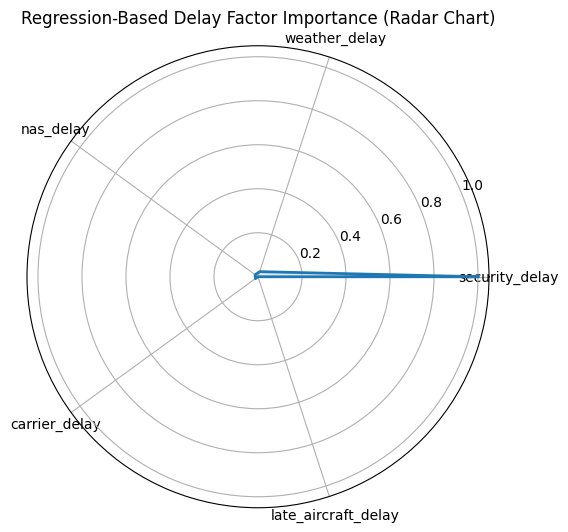

In [117]:
import numpy as np
import matplotlib.pyplot as plt

factors = coef_df["Factor"].values
values = coef_df["Abs_Coefficient"].values

# Normalize for radar chart:
values_norm = (values - values.min()) / (values.max() - values.min())

angles = np.linspace(0, 2 * np.pi, len(factors), endpoint=False)
angles_cycle = np.concatenate([angles, [angles[0]]])
values_cycle = np.concatenate([values_norm, [values_norm[0]]])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(angles_cycle, values_cycle, linewidth=2)
ax.fill(angles_cycle, values_cycle, alpha=0.15)
ax.set_xticks(angles)
ax.set_xticklabels(factors)
plt.title("Regression-Based Delay Factor Importance (Radar Chart)")
plt.show()
